In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import math
import os.path

import keras
import librosa.feature
import sklearn

import pandas
import numpy
from matplotlib import pyplot as plt

import urbansound8k
import preprocess

Using TensorFlow backend.


In [4]:
data = urbansound8k.load_dataset()
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


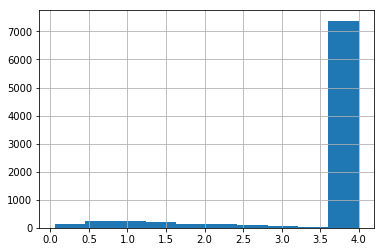

In [5]:
(data.end - data.start).hist()

In [6]:
(data.end-data.start).mode()

0    4.0
dtype: float64

In [7]:
folds, test = urbansound8k.folds(data)
len(folds), folds[0][0].shape, folds[0][1].shape, test.shape

(9, (7022, 8), (873, 8), (837, 8))

In [8]:
# PicakCNN used 950ms, 41 frames for short-frame variant. 50% overlap
def sample_windows(length, frame_samples, window_frames, overlap=0.5):
    """Split @samples into a number of windows of samples
    with length @frame_samples * @window_frames
    """
    ws = frame_samples * window_frames
    start = 0
    while start < length:
        end = min(start + ws, length)
        yield start, end
        start += (ws * (1-overlap))

def test_windows_shorter_than_window():
    frame_samples=256
    window_frames=64
    fs=16000
    length = 0.4*fs
    w = list(sample_windows(int(length), frame_samples, window_frames))
    assert len(w) == 1, len(w)
    assert w[-1][1] == length

def test_window_typical():
    frame_samples=256
    window_frames=64
    fs=16000
    length = 4.0*fs
    w = list(sample_windows(int(length), frame_samples, window_frames))
    assert len(w) == 8, len(w) 
    assert w[-1][1] == length
    
test_windows_shorter_than_window()
test_window_typical()    
    
frame_samples=256
window_frames=72
fs=16000
w_ms = (frame_samples*window_frames/fs)
print('window size', w_ms)
w = list(sample_windows(int(4.0*fs), frame_samples=frame_samples, window_frames=window_frames))
print(w[-2][1] - w[-2][0], w[-1][1] - w[-1][0])
w

window size 1.152
17920.0 8704.0


[(0, 18432),
 (9216.0, 27648.0),
 (18432.0, 36864.0),
 (27648.0, 46080.0),
 (36864.0, 55296.0),
 (46080.0, 64000),
 (55296.0, 64000)]

cutting 7752 samples shorter than 1.0 seconds
37064


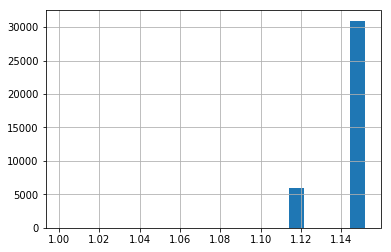

In [9]:
def expand_training_set(samples, frame_samples, window_frames,
                        sample_rate=16000, cut_length=1.0, augmentations=0):
    chunks = {
        'slice_file_name': [],
        'fold': [],
        'classID': [],
        'start': [],
        'end': [],
        'augmentation': [],
    }
    
    for (index, sample) in samples.iterrows():
        duration = sample.end - sample.start
        length = int(sample_rate * duration)
        
        for aug in range(-1, augmentations):
        
            for win in sample_windows(length, frame_samples, window_frames):
                start, end = win
                chunks['slice_file_name'].append(sample.slice_file_name)
                chunks['fold'].append(sample.fold)
                # to assume class is same as that of parent sample maybe a bit optimistic
                # not certain that every chunk has content representative of class
                # alternative would be multi-instance learning
                chunks['classID'].append(sample.classID) 
                chunks['start'].append(start/sample_rate)
                chunks['end'].append(end/sample_rate)
                chunks['augmentation'].append(None if aug == -1 else aug)
            
    df = pandas.DataFrame(chunks)
    
    if cut_length:
        w = (df.end-df.start > cut_length)
        cleaned = df[w]
        print('cutting {} samples shorter than {} seconds'.format(len(df) - len(cleaned), cut_length))
    
    return cleaned

        
df = expand_training_set(folds[0][0], frame_samples=frame_samples, window_frames=window_frames)
print(len(df))
(df.end-df.start).hist(bins=20)  

In [51]:
settings = dict(
    samplerate=16000,
    n_mels=32,
    fmin=0,
    fmax=8000,
    n_fft=512,
    hop_length=256,
    augmentations=5,
)

# TODO: implement data augmentation
def load_sample(sample, window_frames=72):
    n_mels = settings['n_mels']
    sample_rate = settings['samplerate']
    hop_length = settings['hop_length']
    
    # Load precomputed features
    aug = None
    folder = os.path.join('aug', preprocess.settings_id(settings, feature='mels'))
    path = preprocess.feature_path(sample, out_folder=folder, augmentation=aug)
    mels = numpy.load(path)['arr_0']
    assert mels.shape[0] == n_mels, mels.shape
    
    # Cut out the relevant part
    #sample_length = (sample.end - sample.start) * sample_rate

    windows = 7
    features = numpy.zeros(shape=(windows, n_mels, window_frames))
    for i, win in enumerate(sample_windows(mels.shape[1], 1, window_frames)):
        start, end = int(win[0]), int(win[1])
        #print(mels.shape[1], start, end)
        mels = mels[:, start:end]

        if mels.shape[1] > 0:
            mels = librosa.core.power_to_db(mels, top_db=80, ref=numpy.max)

        # zero-pad window to standard length
        if window_frames is None:
            padded = mels
        else:
            padded = numpy.full((n_mels, window_frames), 0)    
            inp = mels[:, 0:min(window_frames, mels.shape[1])]
            padded[:, 0:inp.shape[1]] = inp

        if i < windows:
            features[i, :, :] = padded
    
    s = numpy.stack(features)
    return s

load_sample(folds[0][0].iloc[8]).shape

(7, 32, 72)

In [52]:
import joblib
def gen(X, Y, loader, batchsize=10, n_classes=10):
    
    assert len(X) == len(Y), 'X and Y must be equal length'
    assert len(X) % batchsize == 0, 'input length must be divisible by @batchsize'
        
    sample_idx = 0
    while True:
        batch_data = []
        batch_labels = []

        if sample_idx >= len(X):
            sample_idx = 0
        
        while len(batch_data) < batchsize:
            data = loader(X.iloc[sample_idx])
            data = numpy.expand_dims(data, -1)    
            y = Y.iloc[sample_idx]
            y = keras.utils.to_categorical(y, num_classes=n_classes)
            batch_data.append(data)
            batch_labels.append(y)
            sample_idx += 1
            
        batch = (numpy.stack(batch_data), numpy.stack(batch_labels))
        yield batch

fold = df
import itertools
g = gen(fold[0:16], fold.classID[0:16], loader=load_sample, batchsize=8)
batches = list(itertools.islice(g, 16))
len(batches), batches[0][0].shape, batches[0][1].shape

(16, (8, 7, 32, 72, 1), (8, 10))

In [60]:
# import dense
import sbcnn
import dilated
#model = dilated.build_model(bands=32, frames=72, channels=1, kernels=[32,32,32,32])
model = sbcnn.build_model(bands=32, frames=72, channels=1, pool=(3,3))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 72, 24)        240       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 24, 24)        0         
_________________________________________________________________
activation_26 (Activation)   (None, 10, 24, 24)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 10, 24, 48)        10416     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 3, 8, 48)          0         
_________________________________________________________________
activation_27 (Activation)   (None, 3, 8, 48)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 1, 6, 48)          20784     
__________

In [61]:
def build_multi_instance(base, windows=7, bands=32, frames=72, channels=1):
    from keras import Model
    from keras.layers import Input, TimeDistributed, GlobalAveragePooling1D
    
    input_shape = (windows, bands, frames, channels)
    
    input = Input(shape=input_shape)
    x = input # BatchNormalization()(input)
    x = TimeDistributed(base)(x)
    x = GlobalAveragePooling1D()(x)
    model = Model(input,x)
    return model
    
model = build_multi_instance(model)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 7, 32, 72, 1)      0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 7, 10)             50586     
_________________________________________________________________
global_average_pooling1d_9 ( (None, 10)                0         
Total params: 50,586
Trainable params: 50,586
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def expand_set(samples, ):
    

In [67]:
# Clean model
model = sbcnn.build_model(bands=32, frames=72, channels=1, pool=(3,3))
model = build_multi_instance(model)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#train = expand_training_set(folds[0][0], frame_samples=frame_samples, window_frames=window_frames,
#                            augmentations=settings['augmentations'])
#val = expand_training_set(folds[0][1], frame_samples=frame_samples, window_frames=window_frames)

train = folds[0][0]
val = folds[0][1]
print(train.shape, val.shape)

train = train.sample(7000, replace=False)
val = val.sample(700, replace=False)

batch_size = 100

checkpoint = keras.callbacks.ModelCheckpoint('multi.sbcnn.hdf5', monitor='val_acc', mode='max',
                             period=1, verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

train_gen = gen(train, train.classID, loader=load_sample, batchsize=batch_size)
val_gen = gen(val, val.classID, loader=load_sample, batchsize=batch_size)

model.fit_generator(train_gen, validation_data=val_gen,
                    steps_per_epoch=math.ceil(len(train)/batch_size),
                    validation_steps=math.ceil(len(val)/batch_size),
                    callbacks=callbacks_list,
                    epochs=20, verbose=1)

(7022, 8) (873, 8)
Epoch 1/20
70/70 [==============================] - 52s 746ms/step - loss: 2.3477 - acc: 0.1710 - val_loss: 2.2778 - val_acc: 0.1714

Epoch 00001: val_acc improved from -inf to 0.17143, saving model to multi.sbcnn.hdf5
Epoch 2/20
70/70 [==============================] - 52s 750ms/step - loss: 2.1113 - acc: 0.3587 - val_loss: 2.1173 - val_acc: 0.3257

Epoch 00002: val_acc improved from 0.17143 to 0.32571, saving model to multi.sbcnn.hdf5
Epoch 3/20
70/70 [==============================] - 75s 1s/step - loss: 2.0355 - acc: 0.4147 - val_loss: 2.0557 - val_acc: 0.3786

Epoch 00003: val_acc improved from 0.32571 to 0.37857, saving model to multi.sbcnn.hdf5
Epoch 4/20
70/70 [==============================] - 49s 702ms/step - loss: 1.9972 - acc: 0.4411 - val_loss: 1.9761 - val_acc: 0.4657

Epoch 00004: val_acc improved from 0.37857 to 0.46571, saving model to multi.sbcnn.hdf5
Epoch 5/20
70/70 [==============================] - 50s 717ms/step - loss: 1.9695 - acc: 0.4594 - v

KeyboardInterrupt: 

In [510]:
model = keras.models.load_model('sbcnn.hdf5')

In [511]:
import collections

def predict_windowed(model, samples, method='mean'):
    sample_rate = settings['samplerate']
    
    Sample = collections.namedtuple('Sample', 'start end fold slice_file_name')
    
    out = []
    for _, sample in samples.iterrows():    
        duration = sample.end - sample.start
        length = int(sample_rate * duration)
        windows = []
        
        for win in sample_windows(length, frame_samples, window_frames):
            chunk = Sample(start=win[0]/sample_rate,
                           end=win[1]/sample_rate,
                           fold=sample.fold,
                           slice_file_name=sample.slice_file_name)    
            d = load_sample(chunk)
            windows.append(d)

        inputs = numpy.stack(windows)
        inputs = numpy.expand_dims(inputs, axis=-1)
        predictions = model.predict_proba(inputs)
        
        if method == 'mean':
            p = numpy.mean(predictions, axis=0)
            assert len(p) == 10
            out.append(numpy.argmax(p))
        elif method == 'majority':
            votes = numpy.argmax(predictions, axis=1)
            p = numpy.argmax(numpy.bincount(votes))
            out.append(p)
        
    return numpy.stack(out)

from sklearn.metrics import accuracy_score

t = test
mean_m = predict_windowed(model, t, method='majority')
accuracy_score(t.classID, mean_m)

0.6750298685782556

In [512]:
mean_p = predict_windowed(model, t, method='mean')
accuracy_score(t.classID, mean_p)

0.6535244922341696

In [513]:
val_d = folds[0][1]
val_p = predict_windowed(model, val_d, method='mean')
accuracy_score(val_d.classID, val_p)

0.6368843069873997

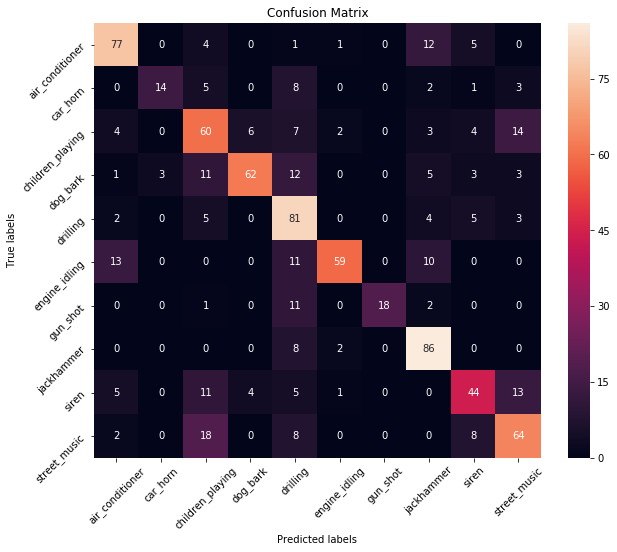

In [516]:
import seaborn as sns
import matplotlib.pyplot as plt     

def plot_confusion(cm, classnames):

    fig, ax = plt.subplots(1, figsize=(10,8))
    sns.heatmap(cm, annot=True, ax=ax);

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classnames, rotation=45)
    ax.yaxis.set_ticklabels(classnames, rotation=45)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_d.classID, val_p, labels=None, sample_weight=None)
cm =confusion_matrix(t.classID, mean_m, labels=None, sample_weight=None)
plot_confusion(cm, urbansound8k.classnames)

In [491]:
data.groupby(['fold', 'class'])['classID'].count()

fold  class           
1     air_conditioner     100
      car_horn             36
      children_playing    100
      dog_bark            100
      drilling            100
      engine_idling        96
      gun_shot             35
      jackhammer          120
      siren                86
      street_music        100
2     air_conditioner     100
      car_horn             42
      children_playing    100
      dog_bark            100
      drilling            100
      engine_idling       100
      gun_shot             35
      jackhammer          120
      siren                91
      street_music        100
3     air_conditioner     100
      car_horn             43
      children_playing    100
      dog_bark            100
      drilling            100
      engine_idling       107
      gun_shot             36
      jackhammer          120
      siren               119
      street_music        100
                         ... 
8     air_conditioner     100
      car_horn   

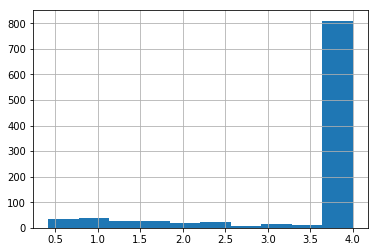

In [482]:
drilling = data[data['class'] == 'drilling']
(drilling.end - drilling.start).hist()

In [498]:
drilling.groupby('fold').head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
196,103199-4-0-0.wav,103199,0.000000,4.000000,1,3,4,drilling
197,103199-4-0-3.wav,103199,1.500000,5.500000,1,3,4,drilling
198,103199-4-0-4.wav,103199,2.000000,6.000000,1,3,4,drilling
199,103199-4-0-5.wav,103199,2.500000,6.500000,1,3,4,drilling
200,103199-4-0-6.wav,103199,3.000000,7.000000,1,3,4,drilling
201,103199-4-1-0.wav,103199,16.097136,17.617205,2,3,4,drilling
202,103199-4-2-0.wav,103199,17.617205,21.617205,1,3,4,drilling
203,103199-4-2-1.wav,103199,18.117205,22.117205,1,3,4,drilling
204,103199-4-2-10.wav,103199,22.617205,26.617205,1,3,4,drilling
205,103199-4-2-11.wav,103199,23.117205,27.117205,1,3,4,drilling
